# Mount Google Drive

In [ ]:
from google.colab import drive; drive.mount('/content/drive')
curDir = !pwd
%cd drive/MyDrive/EE526_Project/
!ls

Mounted at /content/drive
/content/drive/MyDrive/EE526_Project
agenticLP.py		   mathCrowGpt4o.ipynb	 reviewAltGDMinTxt.txt
agenticRAG2Tools.py	   __pycache__		 strawberry.md
agenticRAGAltGDMin.py	   reviewAltGDMin.md	 strawberry.txt
agenticRAGStrawberry.py    reviewAltGDMinNew.md  utils.py
mathCrowGpt4.1-mini.ipynb  reviewAltGDMin.pdf


# Install pacakges


In [ ]:
!pip install\
  langgraph\
  langchain\
  langchain-community\
  langchain-core\
  langchain-huggingface\
  langchain-text-splitters\
  langchain-ollama\
  huggingface-hub\
  faiss-cpu\
  sentence-transformers\
  requests\
  beautifulsoup4\
  pypdf\
  langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.5/443.5 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/

In [ ]:
from langgraph.graph import StateGraph, END
import random
import json
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
import pprint
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings.sentence_transformer import (SentenceTransformerEmbeddings)
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from abc import ABC, abstractmethod

# Add Huggingface and OpenAI tokens/keys

In [ ]:
from google.colab import userdata
import getpass
import os
def _set_env(key: str, val: str):
    if key not in os.environ:
        os.environ[key] = val

_set_env("OPENAI_API_KEY", userdata.get('OPEN-AI'))
_set_env("HUGGINGFACEHUB_API_TOKEN", userdata.get('HF_TOKEN'))
_set_env("LANGCHAIN_API_KEY", userdata.get('LANGSMITH'))

# Global Variables

In [ ]:
TOOLS = []
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
MODELNAME = "gpt-4o"#"gpt-4.1" #"gpt-4.1" #"gpt-4.1-nano" gpt-4.1-mini

# Helper functions

In [ ]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [
                f"Document {i+1}:\n\n{d.page_content}\nMetadata: {d.metadata}, Chunk Size: {d}"
                for i, d in enumerate(docs)
            ]
        )
    )

# Vector Store 1 and Retrieval Tool 1 - LRMC Research Paper Review

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain_community.vectorstores import FAISS #Chrome
from langchain_huggingface import HuggingFaceEmbeddings


chunkSize = 200
chunkOverlap =  100
numSearch = 5
numRetain = 5
reRank = 0
hfEmbeddings = HuggingFaceEmbeddings(
    model_name = EMBEDDING_MODEL_NAME,
    show_progress = True,
)
#
loader = TextLoader("reviewAltGDMinTxt.txt")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=chunkSize, chunk_overlap=chunkOverlap)
doc_splits = text_splitter.split_documents(documents)
#pretty_print_docs(doc_splits)
#print("Total number of documents = {num}".format(num = len(doc_splits)))
vectorstore1 = FAISS.from_documents(doc_splits,hfEmbeddings)
retriever1 = vectorstore1.as_retriever(search_kwargs={"k":numSearch})
retriever_tool1 = create_retriever_tool(
    retriever1,
    "retrieve_altgdmin_information",
    "Search and return information on AltGDMin algorithm"
)
TOOLS.append(retriever_tool1)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

# Vector Store 2 and Retrieval Tool 2 - Strawberry Algorithm Review

In [ ]:
chunkSize = 200
chunkOverlap =  100
numSearch = 5
numRetain = 5
reRank = 0
hfEmbeddings = HuggingFaceEmbeddings(
    model_name = EMBEDDING_MODEL_NAME,
    show_progress = True,
)
#
loader = TextLoader("strawberry.txt")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=chunkSize, chunk_overlap=chunkOverlap)
doc_splits = text_splitter.split_documents(documents)
#pretty_print_docs(doc_splits)
#print("Total number of documents = {num}".format(num = len(doc_splits)))
vectorstore2 = FAISS.from_documents(doc_splits,hfEmbeddings)
retriever2 = vectorstore2.as_retriever(search_kwargs={"k":numSearch})
retriever_tool2 = create_retriever_tool(
    retriever2,
    "retrieve_strawberry_information",
    "Search and return information on the strawberry algorithm"
)
TOOLS.append(retriever_tool2)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

# Linear Assignment Tool

In [ ]:
from pydantic import BaseModel, Field
from typing import List, Literal
import numpy as np
from langchain.tools import Tool
from scipy.optimize import linear_sum_assignment

class costMatrixClass(BaseModel):
  M: List[List[float]] = Field(description="This is the cost matrix of float numbers.")

def solveLAP(M):
  A = np.array(M)
  row_ind, col_ind = linear_sum_assignment(A)
  return {"messages": [row_ind,col_ind]}
  #return M_np

# Create a Tool instance
squareTool = Tool.from_function(
    func=solveLAP,
    name="squareMatrix",
    description="Solves linear assignment problem (LAP).",
    args_schema=costMatrixClass)

TOOLS.append(squareTool)

# Graph Nodes and Conditional Edges

In [ ]:
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage
from langchain import hub
from langchain_openai import ChatOpenAI
from typing import Literal


# Node
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    #print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model=MODELNAME)
    #model = ChatOllama(temperature=0, model=MODELNAME,streaming=True)
    model = model.bind_tools(TOOLS)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Conditional Edge
def router(state) -> Literal["generate", "rewrite", "LAP"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    #print("---CHECK RELEVANCE---")
    messages = state["messages"]
    if hasattr(messages[-2],"tool_calls"):
          toolName =  messages[-2].tool_calls[0]["name"]
    else:
      toolName = "none"

    if toolName == "squareMatrix":
      return "LAP"
    else:
      # Data model
      class grade(BaseModel):
          """Binary score for relevance check."""
          binary_score: str = Field(description="Relevance score 'yes' or 'no'")

      # LLM
      model = ChatOpenAI(temperature=0, model=MODELNAME, streaming=True)
      # LLM with tool and validation
      llm_with_tool = model.with_structured_output(grade)
      prompt = PromptTemplate(
          template="""You are a grader assessing relevance of a retrieved document to a user question. \n
          Here is the retrieved document: \n\n {context} \n\n
          Here is the user question: {question} \n
          If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
          Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
          input_variables=["context", "question"],
      )

      # Chain
      chain = prompt | llm_with_tool

      last_message = messages[-1]

      question = messages[0].content
      docs = last_message.content
      scored_result = chain.invoke({"question": question, "context": docs})
      score = scored_result.binary_score
      if score == "yes":
          #print("---DECISION: DOCS RELEVANT---")
          return "generate"
      else:
          #print("---DECISION: DOCS NOT RELEVANT---")
          #print(score)
          return "rewrite"

# Node
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    #print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model=MODELNAME, streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}

# Node
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    #print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name=MODELNAME, temperature=0, streaming=True)
    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

# Node
def LAP(state):
    """
    Solve the assignment problem

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    #print("---SOLVE---")
    messages = state["messages"]
    return {"messages": messages[-1]}



#print("ChunkSize = {chunkSize}, chunkOverlap = {chunkOverlap}, numSearch = {numSearch}, numRetain = {numRetain}, reRank = {reRank}".format(chunkSize=chunkSize,chunkOverlap=chunkOverlap, numSearch=numSearch, numRetain=numRetain, reRank=reRank))
#print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
#prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

# Compile Graph

In [ ]:
from typing import Annotated, Sequence
from langgraph.prebuilt import tools_condition
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from typing_extensions import TypedDict


# NODES
class AgentState(TypedDict):
    # The add_messages function defines how an update should be processe  Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]
# Define a new graph
workflow = StateGraph(AgentState)
# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
myTools = ToolNode(TOOLS)
workflow.add_node("myTools", myTools)  # all three tools
workflow.add_node("LAP", LAP)  # Linear Assignment
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant
#-------------------------------------------------------------------------------------------------------------
# EDGES
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")
# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "myTools",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "myTools",
    router,
)
workflow.add_edge("LAP", END)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")
graph = workflow.compile()

# Visualize Graph of Mathcrow

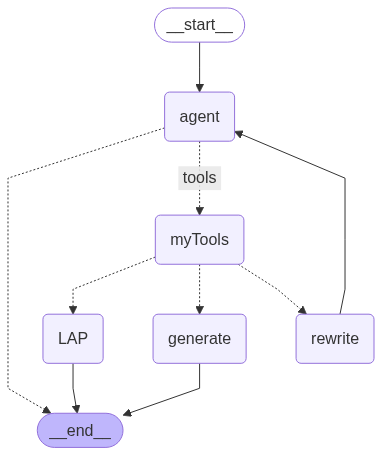

In [ ]:
%pip install -qU langgraph
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)))
except Exception:
    pass

# Examples of Tool 1 Usage - RAG AltGDMin

In [ ]:
import pprint
questions = [
    "What is the AltGDMin algorithm?",
    "How is AltGDMin different from alternating minimization?",
    "How is AltGDMin different from convex optimization?",
    "What is the minimization problem of the AltGDMin algorithm for LRMC?",
    "What is Newton's method?"]
for i in range(len(questions)):
  pprint.pprint("-----------------------------")
  inputs = {"messages": [("user", questions[i])]}
  found = False
  for output in graph.stream(inputs):
    for key, value in output.items():
      if key == "generate":
        found = True
        pprint.pprint("Question = {ques}".format(ques = inputs["messages"]))
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
        pprint.pprint("\n---\n")

  if found == False:
    pprint.pprint("Question = {ques}".format(ques = inputs["messages"]))
    pprint.pprint("---")
    pprint.pprint("I don't know. Context not relevant. ", indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")
  pprint.pprint("-----------------------------")

'-----------------------------'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

"Question = [('user', 'What is the AltGDMin algorithm?')]"
'---'
{ 'messages': [ 'The AltGDMin algorithm is a modification of the AltMin '
                'algorithm designed to be faster and more '
                'communication-efficient for certain problems. It replaces the '
                'slower of the two minimization steps in AltMin with a single '
                'gradient descent (GD) step, making it particularly useful for '
                'problems where the cost function is differentiable with '
                'respect to one set of variables. This approach is beneficial '
                'for partly decoupled problems, such as robust matrix '
                'completion and robust low-rank matrix completion (LRCS).']}
'\n---\n'
'-----------------------------'
'-----------------------------'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

("Question = [('user', 'How is AltGDMin different from alternating "
 "minimization?')]")
'---'
{ 'messages': [ 'AltGDMin differs from alternating minimization (AltMin) in '
                'that it is designed for optimization problems that are '
                '"partly decoupled," allowing for faster solutions by solving '
                'smaller-dimensional minimization problems over disjoint '
                'subsets. AltGDMin often provides a communication-efficiency '
                'advantage in distributed or federated settings, even when '
                'both problems are decoupled. It is particularly beneficial '
                'when one of the minimizations is decoupled and fast, while '
                'the other is not.']}
'\n---\n'
'-----------------------------'
'-----------------------------'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

"Question = [('user', 'How is AltGDMin different from convex optimization?')]"
'---'
{ 'messages': [ 'AltGDMin differs from convex optimization primarily in terms '
                'of speed and efficiency. It is faster and more '
                'communication-efficient than both AltMin and convex '
                'relaxation methods, which are known to be slower due to their '
                'higher iteration and computational costs. AltGDMin is '
                'particularly advantageous for problems where one of the '
                'minimizations is decoupled and can be solved quickly, making '
                'it more suitable for distributed or federated settings.']}
'\n---\n'
'-----------------------------'
'-----------------------------'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

("Question = [('user', 'What is the minimization problem of the AltGDMin "
 "algorithm for LRMC?')]")
'---'
{ 'messages': [ 'The minimization problem of the AltGDMin algorithm for LRMC '
                'involves updating \\( B \\) by minimizing the function \\( '
                'f(U, B) \\), specifically obtaining \\( B_t := \\arg \\min '
                'f(U_{t-1}, B) \\). The goal is to minimize the expected '
                'gradient \\( E[\\nabla_U f(U, B)] = (X - X^*)B^\\top \\), '
                'where \\( X := UB \\).']}
'\n---\n'
'-----------------------------'
'-----------------------------'
'Question = [(\'user\', "What is Newton\'s method?")]'
'---'
"I don't know. Context not relevant. "
'\n---\n'
'-----------------------------'


# Examples of Tool 2 Usage - RAG Strawberry

In [ ]:
import pprint
questions = [
    "What is the strawberry Algorithm?",
    "What are the evlaulation metrics for strawberry algorithm?",
    "What algorithms is the strawberry algorithm compared to?",
    "What do the authors of strawberry use expecetation maximization (EM) for?",
    "What is Newton's method?"]
for i in range(len(questions)):
  pprint.pprint("-----------------------------")
  inputs = {"messages": [("user", questions[i])]}
  found = False
  for output in graph.stream(inputs):
    for key, value in output.items():
      if key == "generate":
        found = True
        pprint.pprint("Question = {ques}".format(ques = inputs["messages"]))
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
        pprint.pprint("\n---\n")

  if found == False:
    pprint.pprint("Question = {ques}".format(ques = inputs["messages"]))
    pprint.pprint("---")
    pprint.pprint("I don't know. Context not relevant. ", indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")
  pprint.pprint("-----------------------------")

'-----------------------------'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

"Question = [('user', 'What is the strawberry Algorithm?')]"
'---'
{ 'messages': [ 'The Strawberry Algorithm is a method for fast and accurate '
                'genome-guided transcript reconstruction and quantification '
                'from RNA-seq data. It improves computational efficiency by '
                'grouping reads based on exon bins and uses a flow network '
                'algorithm to parsimoniously build up transcripts. Unlike '
                'other methods, Strawberry focuses on transcript assembly '
                'rather than quantification.']}
'\n---\n'
'-----------------------------'
'-----------------------------'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

("Question = [('user', 'What are the evlaulation metrics for strawberry "
 "algorithm?')]")
'---'
{ 'messages': [ 'The evaluation metrics for the Strawberry algorithm include '
                'sensitivity and specificity, as well as the accuracy of '
                'transcript assembly and quantification. Strawberry is noted '
                'for producing more accurate transcripts compared to other '
                'methods like StringTie and Cufflinks, and it achieves over '
                '92% correlation with the ground truth in simulated RNA-seq '
                'data.']}
'\n---\n'
'-----------------------------'
'-----------------------------'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

("Question = [('user', 'What algorithms is the strawberry algorithm compared "
 "to?')]")
'---'
{ 'messages': [ 'The strawberry algorithm is compared to Cufflinks and '
                'StringTie.']}
'\n---\n'
'-----------------------------'
'-----------------------------'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

("Question = [('user', 'What do the authors of strawberry use expecetation "
 "maximization (EM) for?')]")
'---'
"I don't know. Context not relevant. "
'\n---\n'
'-----------------------------'
'-----------------------------'
'Question = [(\'user\', "What is Newton\'s method?")]'
'---'
"I don't know. Context not relevant. "
'\n---\n'
'-----------------------------'


# Example of Tool 3 Usage - Linear Assignment Problem Solver

In [ ]:
inputPrompt = """ A manager needs to assign 3 workers to 3 jobs.\
Each worker can do any job, but the cost of assigning each worker to each job is different.
#### **Cost Matrix (in dollars):**
|          | Job 1 | Job 2 | Job 3 |
| -------- | ----- | ----- | ----- |
| Worker 1 | 9     | 2     | 7     |
| Worker 2 | 6     | 4     | 3     |
| Worker 3 | 5     | 8     | 1     |
---
### **Objective:**
Assign each worker to one unique job so that the **total cost is minimized**."""

inputs = {"messages": [("user", inputPrompt)]}
for output in graph.stream(inputs):
  for key, value in output.items():
      if key == "LAP":
        found = True
        pprint.pprint("---")
        a = value['messages']
        pprint.pprint(value['messages'].content, indent=2, width=80, depth=None)
        pprint.pprint("\n---\n")

'---'
"{'messages': [array([0, 1, 2]), array([1, 0, 2])]}"
'\n---\n'


In [ ]:
inputPrompt = """A logistics firm is planning to deploy four delivery drones (D1, D2, D3, D4) to deliver urgent packages to four distinct city zones (Z1, Z2, Z3, Z4). However, each drone has a varying level of battery efficiency and signal stability, making them more or less suited to particular zones.

Each zone has unique geographical characteristics (like signal interference, wind patterns, and airspace restrictions), and assigning a drone to a suboptimal zone can result in delayed delivery and higher battery consumption. The estimated cost (in minutes of delay) of assigning each drone to each zone, after factoring in terrain, air traffic, and drone characteristics, is given in the table below:

Z1	Z2	Z3	Z4
D1	9	2	7	8
D2	6	4	3	7
D3	5	8	1	8
D4	7	6	9	4

The company’s objective is to minimize the total delivery delay by assigning each drone to exactly one zone and each zone to exactly one drone.

However, note the following complicating conditions:

Due to a recent update in drone firmware, Drone D3 should not be assigned to Zone Z2.

Drone D2 must be assigned to either Zone Z2 or Z3 because of its signal calibration.

Assignments must be exclusive — no two drones can be assigned to the same zone."""

inputs = {"messages": [("user", inputPrompt)]}
for output in graph.stream(inputs):
  for key, value in output.items():
      #if key == "LAP":
      found = True
      pprint.pprint("---")
      pprint.pprint(value['messages'], indent=2, width=80, depth=None)
      pprint.pprint("\n---\n")

'---'
[ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_Tns5ftxtMGBXaSsIkY59plES', 'function': {'arguments': '{"M":[[9,2,7,8],[6,4,3,7],[5,1000,1,8],[7,6,9,4]]}', 'name': 'squareMatrix'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'service_tier': 'default'}, id='run--57086791-739a-4593-9911-19bdb14eba09-0', tool_calls=[{'name': 'squareMatrix', 'args': {'M': [[9, 2, 7, 8], [6, 4, 3, 7], [5, 1000, 1, 8], [7, 6, 9, 4]]}, 'id': 'call_Tns5ftxtMGBXaSsIkY59plES', 'type': 'tool_call'}])]
'\n---\n'
'---'
[ ToolMessage(content="{'messages': [array([0, 1, 2, 3]), array([1, 0, 2, 3])]}", name='squareMatrix', id='29f4ef1f-c727-4730-9515-36fb6d491913', tool_call_id='call_Tns5ftxtMGBXaSsIkY59plES')]
'\n---\n'
'---'
ToolMessage(content="{'messages': [array([0, 1, 2, 3]), array([1, 0, 2, 3])]}", name='squareMatrix', id='29f4ef1f-c727-4730-9515-36fb6d491913', tool_call